# Re-analysing ILL Y(Mn1-xFex)2 Data

This data was collected 15th July, 2000 (the logbook says 2002, I have no idea why, 2000 sounds right).  In those days, there was no event mode, so this analysis recreates events by sampling the histograms.  This is a good test of the method, because we already know what the traditional analysis shows, and we should be able to reproduce the result.

## Papers / Reading material

* [Li et al, A tutorial on Dirichlet process mixture modeling](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6583910/)
* [Foreman-Mackey, Mixture Models](https://dfm.io/posts/mixture-models/)
* [Hogg et al, Data analysis recipes: Fitting a model to data](https://arxiv.org/abs/1008.4686)


## IMPORTANT NOTE:

At the end of wrangling with pymc with little success, I decided to switch over to a barebones MCMC sampler called "emcee" and do the inference by hand. 

## Histogram Functions

The first step is to recreate a few of the basic workflow functions before we re-sample the histograms as events.

Some curiosities:
* The LAMP code s_normalise.pro, which normalises the data to monitor counts etc, multiplies the run counts by 1000 before dividing by the monitor counts.  This is odd.
* My radial average code is almost precisely 0.5 times the output of the ILL code, neglecting some small sampling errors and systematics.  A factor of 2 difference is always suspicious but I can't see where it is.  I use the same algorithm as in LAMP basically.
* If I normalise by monitor counts like in LAMP then the scaling factor difference is almost exactly pi * root(2), maybe this is a solid angle correction?
* It appears that the LAMP code from 20 years ago doesn't actually pay any attention to the perspex ("water") run (there is SANS in it and so a systematic error) or the cadmium run (the background is so small anyway you can just ignore it).
* My fits with lmfit produce different parameters with the same data.
* It looks like the LAMP code does not shift the x values to the histogram bin centre, but rather keeps the low-x edge.


In [1]:
import numpy as np
import scipy as sp
import emcee

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import tqdm

def plot_detector_map(data, log_scale=True):
    if log_scale:
        data = np.log(data)
    plt.imshow(data,  interpolation='nearest', cmap=cm.viridis)
    
def detector_distance_from(num):
    # Returns detector distance value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
            
    comment_block_length = 26
        
    detector_distance_line_index = [37+comment_block_length]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    detector_distance_index = 3
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    
    return(det)

    
def wavelength_from(num):
    # Returns wavelength value from run
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
 
    comment_block_length = 26
        
    wavelength_line_index = [44+comment_block_length]
        
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
        
    wavelength_index = 2
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    
    return wavelength
    
def temperature_from(num):
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    datafile.close()
        
    comment_block_length = 26
    temperature_line_index = [40+comment_block_length]
    temperature_line = [lines[i].strip() for i in temperature_line_index]        
    temperature_index = 0
        
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )

    return(temp)

    
def read_run(num, info=False, plot=False):
    # Reads an individual run in ancient ILL D11 format
    
    path = "data/ill/d11/ymnfe2/"
    fnum = str(num).zfill(6)
    fullname = path + fnum
    print(fullname)
    
    
    datafile = open(fullname, 'r')
    lines=datafile.readlines()
    meta_elements = [25, 26]
    meta = [lines[i].strip() for i in meta_elements]
        
    comment_block_length = 26
        
    detector_line_index = [34+comment_block_length]
    detector_distance_line_index = [37+comment_block_length]
    temperature_line_index = [40+comment_block_length]
    wavelength_line_index = [44+comment_block_length]
    collimation_line_index = [45+comment_block_length]
        
    detector_line = [lines[i].strip() for i in detector_line_index]
    detector_distance_line = [lines[i].strip() for i in detector_distance_line_index]
    temperature_line = [lines[i].strip() for i in temperature_line_index]
    wavelength_line = [lines[i].strip() for i in wavelength_line_index]
    collimation_line = [lines[i].strip() for i in collimation_line_index]
        
    detector_sum_index = 3
    monitor_sum_index = 4
    detector_distance_index = 3
    temperature_index = 0
    wavelength_index = 2
    collimation_index = 2
        
        
    detector_sum = np.float_( detector_line[0].split("  ")[detector_sum_index] )
    monitor_sum = np.float_( detector_line[0].split("  ")[monitor_sum_index] )
    det = np.float_( detector_distance_line[0].split("  ")[detector_distance_index] )
    temp = np.float_( temperature_line[0].split("  ")[temperature_index] )
    wavelength = np.float_( wavelength_line[0].split("  ")[wavelength_index] )
    collimation = np.float_( collimation_line[0].split("  ")[collimation_index] )
    
    datafile.close()

        
    if info:
        print(meta[0])
        print(meta[1])
        
        print("Det. sum:", detector_sum)
        print("Mon. sum:", monitor_sum)
        print("Det. distance:", det)
        print("Temp:", temp)
        print("Wavelength:", wavelength)
        print("Collimation:", collimation)

    
    
    # Get some info on run
    datafile = open(fullname, 'r')
    
    # Legacy ILL data for D11 has 118 header rows
    lines=datafile.readlines()[118:]#skiprows=118)
    

    
    datafile.close()
    
    
    # The data is a 64x64 detector, but the histo
    # counts are recorded with 10 columns in sequence
    # Probably a fortran thing from back in the day
    
    data = []
    
    for line in lines:
        data += line.strip().split(" ")
        
    # Now we have each histo entry space separated
    # but we also have a lot of empty values
    # Each space character was stored.  Remove empty entries
    sdata = list(filter(None, data))
    
    # Convert strings to numpy array of floats
    ndata = np.float_(sdata)
    
    # Re-arrange into 64x64 grid of detector pixels
    ndata = ndata.reshape(64,64)
    
    # plot if necessary
    if plot:
        plot_detector_map(ndata)
    
    # It looks like this is the correct orientation,
    # with gravity downwards, in plt.imshow.  No rotation 
    # is required.
    # This is an array with [y, x] indices starting top-left
    
    return ndata, detector_sum, monitor_sum


def read_sum(run1, run2, plot=False):
    # Reads multiple runs and sums up the data
    
    data, detector_sum, monitor_sum = read_run(run1, plot=False, info=False)
    
    for run in range(run1+1, run2+1):
        new_data, new_dsum, new_msum = read_run(run, plot=False, info=False)
        data = data + new_data
        detector_sum = detector_sum + new_dsum
        monitor_sum = monitor_sum + new_msum
        
    if plot:
        plot_detector_map(data)
    
    return data, detector_sum, monitor_sum
    
    
    

    
def bleed_mask(mask):
    # takes mask data and bleeds it one pixel over

    # Bleed in y direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if iy < 63:
                if mask[iy+1, ix] < 0.5:
                    mask[iy, ix] = 0.0
    
    # Bleed in y direction negative
    for iy in range(63, -1, -1):
        for ix in range(0, 64):
            if iy > 0:
                if mask[iy-1, ix] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction positive
    for iy in range(0, 64):
        for ix in range(0, 64):
            if ix < 63:
                if mask[iy, ix+1] < 0.5:
                    mask[iy, ix] = 0.0
                    
    # Bleed in x direction negative
    for iy in range(0,64):
        for ix in range(63, -1, -1):
            if ix > 0:
                if mask[iy, ix-1] < 0.5:
                    mask[iy, ix] = 0.0
    
    return mask

def make_mask(water):
    # uses a water run to make a mask.  Manually masks edges of detector
    # Finds the beamstop area and the detector boundaries by average
    # comparison
    
    mask = np.ones_like(water)
    
    left_panel = water[12:50,1:20]
    right_panel = water[12:50,1:61]
    top_panel = water[1:12,20:50]
    bot_panel = water[50:61,20:50]
    trimmed = np.concatenate((\
        left_panel.flatten(),\
        right_panel.flatten(),\
        top_panel.flatten(),\
        bot_panel.flatten()))
    
    mask_mean = np.mean(trimmed)
    mask_stddev = np.std(trimmed)
        
    threshold = mask_mean - mask_stddev
    

    
    
    fail = water < threshold
    
    mask[fail] = 0.0    

    mask = bleed_mask(mask)

    # manual edges
    mask[:,0]=0.0
    mask[0,:]=0.0
    mask[:,63] = 0.0
    mask[63,:] = 0.0
    
    plot_detector_map(mask, log_scale=False)
    
    return mask



def event_resample(data, detector_distance, wavelength, beam_centre):
    # Takes data, computes Q values and adjusts event weights
    opp = np.zeros_like(data)
    
    events = np.empty(shape=0, dtype=np.float_)
    weights= np.empty(shape=0, dtype=np.float_)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    
    circle_area_diff = (4.0 * np.pi * qval)
    square_approx = np.sqrt(2.0) # difference between area of a square and a circle?
    no_idea_wtf = np.pi # This is obviously there from looking at the data but no clue why
    norm = circle_area_diff / (no_idea_wtf * square_approx)
    
    rounded_data = np.round(data) # Just in case there are some fractional counts for some reason
    
    for iy in tqdm(range(0, 64)):
        for ix in range(0, 64):
            pixel = np.full(shape=int(rounded_data[iy, ix]), fill_value=qval[iy, ix])
            wpixel = np.ones(shape=int(rounded_data[iy, ix]))
            
            wpixel = wpixel / norm[iy, ix]
            
            events = np.append(events, pixel)
            weights= np.append(weights, wpixel)
    
    # shuffle arrays?
    return events, weights
    
    
    
    



def radial_average(data, detector_distance, wavelength, beam_centre, nbins=64, geometric_norm=True, cleanup=True, xshift=False, plot=True, xmin=None, xmax=None, ymin=None, ymax=None):
    # Radially averages the data and converts to Q
    
    opp = np.zeros_like(data)
    
    err_data = np.sqrt(data)
    
    for iy in range(0, 64):
        for ix in range(0, 64):
            yval = iy - beam_centre[1]
            xval = ix - beam_centre[0]
            opp[iy, ix] = np.sqrt(yval**2.0 + xval**2.0)
    
    tanq = 0.01 * opp / detector_distance
    two_theta = np.arctan(tanq)
    
    theta = 0.5 * two_theta
    
    qval = 4.0 * np.pi * np.sin(theta) / wavelength
    qmin = np.amin(qval)
    qmax = np.amax(qval)
    
    bins = np.linspace(qmin, qmax, nbins)
    
    # The normalisation factor for each bin is the radial average
    # of the q values (that just counts how many pixels fall in
    # each bin) if we normalise by pixel, otherwise geometric_norm
    
    bin_width = bins[1]-bins[0]
        
    if geometric_norm:
        # We normalise geometrically - this normalisation factor is what we'd use in event mode
        # However, this seems to result in LAMP / (pi * sqrt(2))
        #geom = data / (2.0 * np.pi * qval)
        
        # This normalisation factor is scaled by some values, but I'm not entirely sure where they come from.
        #.      difference between circle areas / not sure about pi, the The root 2 comes from square grid
        circle_area_diff = (4.0 * np.pi * bin_width * qval)
        square_approx = np.sqrt(2.0) # difference between area of a square and a circle?
        no_idea_wtf = np.pi # This is obviously there from looking at the data but no clue why
        
        
        norm = circle_area_diff / (no_idea_wtf * square_approx)
        geom = data / norm
        err_geom = err_data / data
        #err_data = err_data / norm # err_data / norm
        hst = np.histogram(qval, bins=bins, weights = geom)
        err_hst = np.histogram(qval, bins=bins, weights = err_geom)
        #err_hst = np.sqrt(hst[0])
        
    else:
        # we normalise numerically by counting pixels in each bin - this is the traditional way to do it.  However, this seems to result
        # in 0.5 * LAMP
        norm_hst = np.histogram(qval, bins=bins)
        err_norm = np.sqrt(norm_hst[0])
        
        hst = np.histogram(qval, bins=bins, weights = data)
        err_hst = np.histogram(qval, bins=bins, weights = err_data)
        
        # The mistake here is that you are essentially 
        # dividing by a number, so the error bar should be propagated
        # as a division, not just the sqrt
        
    #err = err[0]
    #err = np.sqrt(hst[0])
    
    
    
    xvals = hst[1]
    
    # Shift the x values to bin-centre
    if xshift:
        print("Shifting x")
        dx = xvals[1]-xvals[0]
        xvals = xvals + 0.5*dx
    else:
        print("Not shifting x")
    
    xplot = xvals[:-1]
    
    if geometric_norm:
        yplot = hst[0]
        err = err_hst[0]
    else:
    # Normalise by pixel:
        yplot = hst[0] / norm_hst[0]
        err = np.sqrt(yplot * (np.square(err_hst[0]/hst[0]) + np.square(err_norm / norm_hst[0])))
        
    
    
    
    if plot:    
        #plt.plot(xplot, yplot, ls='None', marker='o')
        plt.errorbar(xplot, yplot, yerr=err, ls='None', marker='o')
        plt.yscale('log')
        plt.xscale('log')
        if xmin != None and xmax != None:
            plt.xlim([xmin, xmax])
        if ymin != None and ymax != None:
            plt.ylim([ymin, ymax])
            
    # Trim the data to specified ranges
    if xmin != None and xmax != None:
        trim_mask_min = xplot > xmin
        trim_mask_max = xplot < xmax
        trim_mask = trim_mask_min & trim_mask_max
        
        xplot = xplot[trim_mask]
        yplot = yplot[trim_mask]
        err = err[trim_mask]
        
    # Remove any points that are zero if cleanup is true
    if cleanup:
        clean_mask = yplot > 0.0
        xplot = xplot[clean_mask]
        yplot = yplot[clean_mask]
        err = err[clean_mask]
    
    return xplot, yplot, err
    
    
    
def apply_mask(data, mask, plot=True):
    # masks out the data and returns cleaned data
    new_data = data * mask
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data



def norm_water(data, water, data_mon=1.0, water_mon=1.0, divide=False, verbose=False, plot=True):
    # normalises the detector response efficiency based on water run
    
    num_pixels = np.float_(np.sum(water > 0.0))
    
    nanmask = water == 0.0
    
    water_scale = water_mon / data_mon
    
    water = water / water_scale
    
    water_sum = np.sum(water)
    
    water = num_pixels * water / water_sum
    
    if divide:
        water[nanmask] = 1.0
        new_data = data / water
    else:
        new_data = data * water

    
    if verbose:
        print("water scale:", water_mon / data_mon)
        np.set_printoptions(threshold=np.inf)
        print("water norm:")
        print(water)
        np.set_printoptions(threshold=1000)
    
    if(plot):
        plot_detector_map(new_data)
    
    return new_data
    
    
    
    
    
def find_centre(data):
    # Uses a TRANSMISSION RUN to find the beam centre
    # beamcentre.pro in LAMP does a least-squares fit to a gaussian
    # this code does two MLE estimates of gaussian, one for each component
    
    # Weighted mean of pixel coordinate map
    
    # Arrays are indexed [y, x] with origin in top left
    # as plotted in matplotlib imshow

    
    yint = np.sum(data, axis=1) 
    xint = np.sum(data, axis=0)
    
    yint_sum = np.sum(yint)
    xint_sum = np.sum(xint)
        
    yint = yint / yint_sum
    xint = xint / xint_sum
    
    pixval = np.arange(0, 64)
    
    weightedx = pixval * yint
    weightedy = pixval * xint
    
    xcentre = np.sum(weightedx)
    ycentre = np.sum(weightedy)
    
    # We return (x, y) location, but code elsewhere keeps track that the 
    # arrays are arranged (y, x) for imshow...
    return np.array([xcentre, ycentre])
        

def calculate_transmission(sample, air, sample_mon, air_mon, verbose=False):
    
    # D11 has 3 attenuators with the following factors according to the website:
    #fa=8.53 (att 1)
    #fa=26.40 (att 2)
    #fa=68.47 (att 3)
    
    spot_max = np.amax(air)
    spot_region = air > 0.5*spot_max
    
    #spot_max = np.amax(sample)
    #spot_region = sample > 0.0#5*spot_max
    
    air_clip = air[spot_region]
    sample_clip = sample[spot_region]
    
    airsum = np.sum(air_clip)
    ssum = np.sum(sample_clip)
    
    airsum_mon = airsum / air_mon
    ssum_mon = ssum / sample_mon
    
    transmission_mon = ssum_mon / airsum_mon
    transmission = ssum / airsum
    
    if verbose:
        print("airsum", airsum)
        print("ssum", ssum)
        print("airsum_mon", airsum_mon)
        print("ssum_mon", ssum_mon)
        print("transmission_mon", transmission_mon)
        print("transmission", transmission)
    
    return transmission_mon
    

In [2]:
test_a = 1.0
circle_area = 0.25 * np.pi * test_a**2.0
square_area = test_a * test_a

ratio = circle_area / square_area
print(ratio)
print(1.0/np.sqrt(2.0))
print(np.pi / 4.0)

0.7853981633974483
0.7071067811865475
0.7853981633974483


data/ill/d11/ymnfe2/006314
data/ill/d11/ymnfe2/006315
21565.0 21565.0 1199998.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


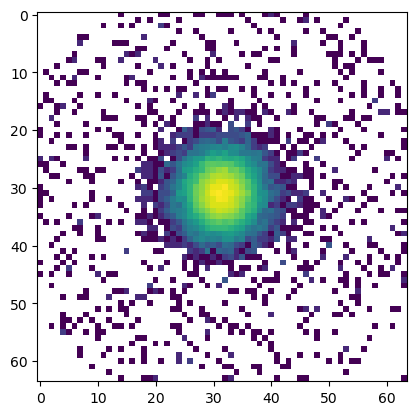

In [3]:
sample_trans, sample_trans_sum, sample_trans_mon = read_sum(6314, 6315, plot=True)
print(np.sum(sample_trans), sample_trans_sum, sample_trans_mon)

data/ill/d11/ymnfe2/006018
Cywinski  ymnfe2                                 5-32-60877 perspex trans
15-JUN-00 13:43:33  15-JUN-00 13:46:39
Det. sum: 264240.0
Mon. sum: 599999.0
Det. distance: 10.0
Temp: 9999.99902
Wavelength: 10.0037508
Collimation: 10.5
264240.0 264240.0 599999.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


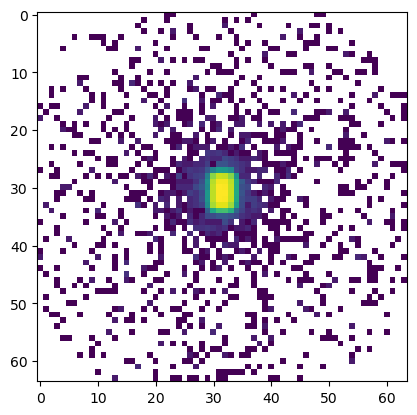

In [4]:
empty_trans, empty_trans_sum, empty_trans_mon = read_run(6018, plot=True, info=True)
print(np.sum(empty_trans), empty_trans_sum, empty_trans_mon)

In [5]:
transmission = calculate_transmission(sample_trans, empty_trans, sample_trans_mon, empty_trans_mon)
print(transmission)

0.010068542849775422


In LAMP, we measured 0.0108, this is good.

data/ill/d11/ymnfe2/006346


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


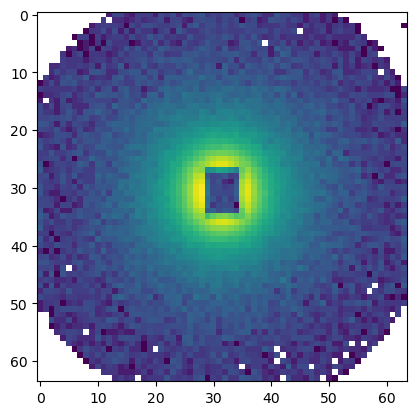

In [6]:
nuclear, non1, nuclear_mon = read_run(6346, plot=True)

data/ill/d11/ymnfe2/006025


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


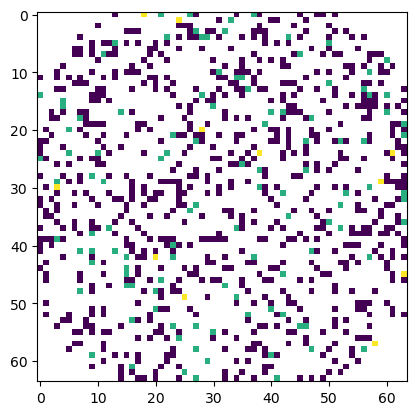

In [7]:
cadmium, non1, non2 = read_run(6025, plot=True)

In [8]:
water, detsum, water_mon = read_sum(6010, 6017)
#water = water - cadmium

data/ill/d11/ymnfe2/006010
data/ill/d11/ymnfe2/006011
data/ill/d11/ymnfe2/006012
data/ill/d11/ymnfe2/006013
data/ill/d11/ymnfe2/006014
data/ill/d11/ymnfe2/006015
data/ill/d11/ymnfe2/006016
data/ill/d11/ymnfe2/006017


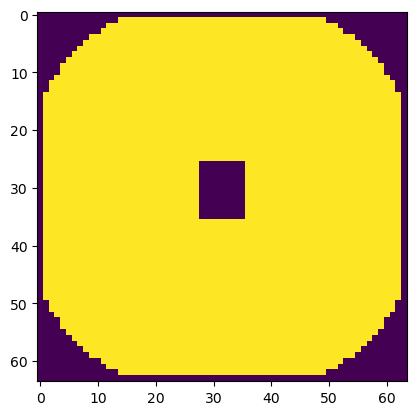

In [9]:
detector_mask = make_mask(water)

In [10]:
ctr_data, ss, mon = read_run(6314, info=True)
print(ss)
beam_centre = find_centre(ctr_data)
print(beam_centre)

data/ill/d11/ymnfe2/006314
Cywinski  ymnfe2                                 5-32-60877 YMnFe0.6 trans
18-JUN-00 22:18:36  18-JUN-00 22:21:43
Det. sum: 12405.0
Mon. sum: 599999.0
Det. distance: 9.9989996
Temp: 101.439003
Wavelength: 9.99982071
Collimation: 10.5
12405.0
[30.92261185 31.36130593]


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


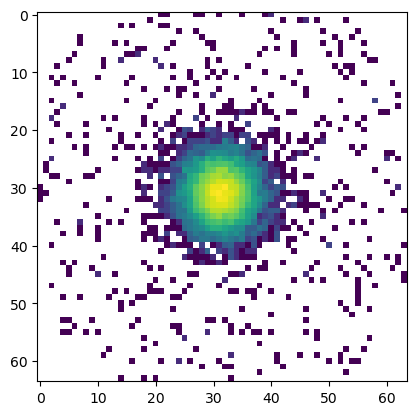

In [11]:
plot_detector_map(ctr_data)

In [12]:
realdat, detsum, data_mon = read_run(6316)
#realdat = realdat - cadmium
#realdat = realdat - nuclear

data/ill/d11/ymnfe2/006316


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


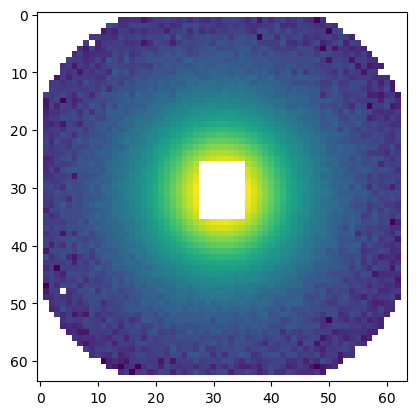

In [13]:
realdat_masked = apply_mask(realdat, detector_mask)

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


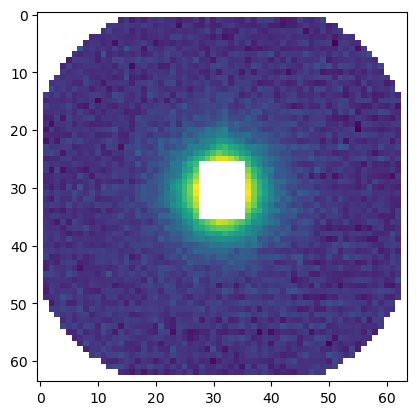

In [14]:
water_masked = apply_mask(water, detector_mask)

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


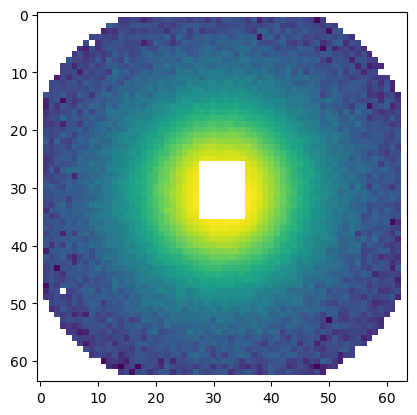

In [15]:
norm_realdat = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon)
norm_divide = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon, divide=True)

The following treatment reconstructs the ILL data using IDL (almost):
* No cadmium subtraction
* No detector efficiency / water calibration
* No shift in x values
* 54 data points in radial average

The anomalous feature of this is the appearance of a factor of 0.5 (or 2.0) in the scaling.  Must investigate.  If I duplicate exactly what happens in LAMP - multiply by 1000 then divide by monitor counts - then I end up needing a factor of 4.5, which is close to pi * root(2), as shown in the code below.

In [16]:
np.pi * np.sqrt(2.0)

4.442882938158366

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:364: RuntimeWarning: invalid value encountered in divide
  err_geom = err_data / data
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:406: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt(yplot * (np.square(err_hst[0]/hst[0]) + np.square(err_norm / norm_hst[0])))


Not shifting x
Not shifting x
Not shifting x
Not shifting x
Tail should be roughly at 13.0


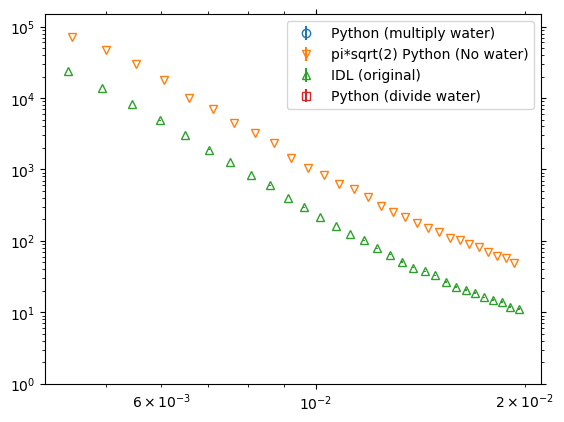

In [17]:
nbins=54

xmin = 0.004
xmax = 0.0195

spec = radial_average(norm_realdat, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)#0.02, ymin=1.0, ymax=10000.0)
divide =radial_average(norm_divide, detector_distance_from(6010), wavelength_from(6010), beam_centre, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)

#check from existing data
old_data = np.loadtxt("/Users/phillipbentley/Experimental_Work/PhD/y(mnfe)2/SANS/xp6/ymnfep6_0.dat", unpack=True,max_rows=30)
old_fit = np.loadtxt("/Users/phillipbentley/Experimental_Work/PhD/y(mnfe)2/SANS/xp6/ymnfep6_0.fit", unpack=True)


# Here is the factor of 2 - use with geometric_norm=False, also gives correct error bars
geometric_norm=False
nowater=radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=geometric_norm, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
scalewatery = 2.0*nowater[1]
scalewaterx = nowater[0]
scalewatere = 2.0*nowater[2]
labeltext="2x Python (No water)"

# If I follow what happens in LAMP, and use geometric_norm=True, then it's a factor of 4.5 - maybe pi * root(2)?
# You can comment this out if necessary to check the factor of 2 above
# The geometric norm thing seems to produce the wrong error bars - need to fix that.
geometric_norm=True
nowater=radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=geometric_norm, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
#scalewatery = np.pi * np.sqrt(2.0) * 1000.0 * nowater[1] / data_mon
# Moving that correction into the radial average code we can do:
scalewatery = 1000.0 * nowater[1] / data_mon
scalewatery = np.pi * np.sqrt(2.0) * nowater[1] / data_mon
scalewatere = np.pi * np.sqrt(2.0) * 1000.0 * nowater[2] / data_mon
# That seems to work, so I have some normalisation here only to fix
labeltext="pi*sqrt(2) Python (No water)"


fig, ax = plt.subplots()
ax.errorbar(spec[0], spec[1], spec[2], fmt='o', mfc='none', label="Python (multiply water)")
ax.errorbar(scalewaterx, scalewatery, scalewatere, fmt='v', mfc='none', label=labeltext)
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="IDL (original)")
ax.errorbar(divide[0], divide[1], divide[2], fmt='s', mfc='none', label="Python (divide water)")
ax.tick_params(top=True, right=True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')
#plt.xlim([0.005, 0.023])
plt.ylim([1.0, 150000.0])
ax.legend()


print("Tail should be roughly at", realdat_masked[32,61])

In [18]:
print(old_data[0][0])
print(scalewaterx[0])
print()
print(old_data[2][0])
print(scalewatere[0])
print()
print(old_data[2][20])
print(scalewatere[20])
print(data_mon)

0.004399
0.004465250851831632

41.061459
nan

0.692626
nan
3000000.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:364: RuntimeWarning: invalid value encountered in divide
  err_geom = err_data / data
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:406: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt(yplot * (np.square(err_hst[0]/hst[0]) + np.square(err_norm / norm_hst[0])))


Not shifting x
Not shifting x
41.061459
nan
31.68587129156906

0.442074
nan
2.0252329633350312

0.0003333333333333333


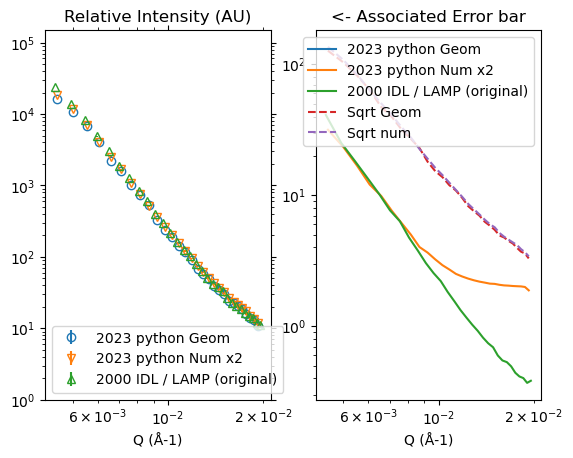

In [19]:
geometric = radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=True, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)
numeric = radial_average(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre, geometric_norm=False, nbins=nbins, xshift=False, plot=False, xmin=xmin, xmax=xmax)

geometric_x = geometric[0]
geometric_y = geometric[1] / data_mon #* np.pi * np.sqrt(2.0) / data_mon
geometric_e = geometric[2] / data_mon #* 4.0 * np.pi)# * np.pi * np.sqrt(2.0) ) # / data_mon


numeric_x = numeric[0]
numeric_y = 2.0 * numeric[1]
numeric_e = 2.0 * numeric[2]

root_geom = np.sqrt(geometric_y)
root_num = np.sqrt(numeric_y)

fig, ax = plt.subplots(1,2)
ax[0].errorbar(geometric_x, geometric_y, geometric_e, fmt='o', mfc='none', label="2023 python Geom")
ax[0].errorbar(numeric_x, numeric_y, numeric_e, fmt='v', mfc='none', label="2023 python Num x2")
ax[0].errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="2000 IDL / LAMP (original)")
ax[0].tick_params(top=True, right=True, which='both')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Q (Å-1)')
ax[0].set_title('Relative Intensity (AU)')
#plt.xlim([0.005, 0.023])
ax[0].set_ylim([1.0, 150000.0])
ax[0].legend()

ax[1].plot(geometric_x, geometric_e, label="2023 python Geom")
ax[1].plot(numeric_x, numeric_e, label="2023 python Num x2")
ax[1].plot(old_data[0], old_data[2], label="2000 IDL / LAMP (original)")
ax[1].plot(geometric_x, root_geom, ls='--', label="Sqrt Geom")
ax[1].plot(numeric_x, root_num, ls='--', label="Sqrt num")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Q (Å-1)')
ax[1].set_title('<- Associated Error bar')
ax[1].legend()

print(old_data[2,0])
print(geometric_e[0])
print(numeric_e[0])
print()
print(old_data[2,25])
print(geometric_e[25])
print(numeric_e[25])
print()
print(1000.0 / data_mon)


[[Model]]
    Model(teubner)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 29
    # variables        = 3
    chi-square         = 9664.13639
    reduced chi-square = 371.697553
    Akaike info crit   = 174.457555
    Bayesian info crit = 178.559442
    R-squared          = 0.99997950
[[Variables]]
    bb:  1.7495e-06 +/- 2.7830e-07 (15.91%) (init = 200)
    cc:  1.2474e-10 +/- 8.4290e-12 (6.76%) (init = 10)
    bg:  0.03492896 +/- 12.4166592 (35548.32%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(bb, cc) = -0.9169
    C(bb, bg) = -0.6342
    C(cc, bg) = +0.5304
zeta: 7.130389164914889e-05
err: 1.232352858426916e-05


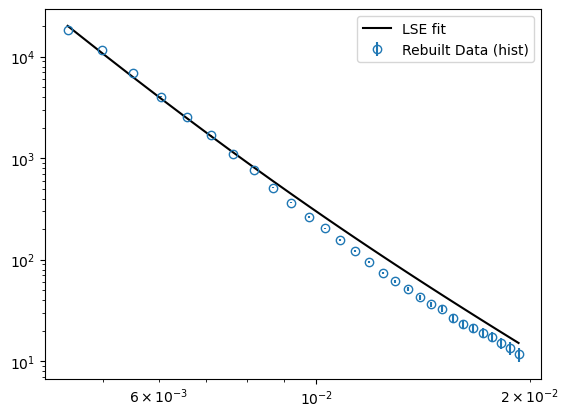

In [20]:
from lmfit import Model

cscale = 1.0E-8
bscale = 1.0E-6
ascale = 1.0E-4

bgscale = 1.0E-5

def teubner(x, bb, cc, bg):
    first = bscale * bb / x**4.0
    second = cscale * cc / x**6.0
    return first + second + bgscale * bg

def teubner_no_bg(x, bb, cc):
    first = bscale * bb / x**4.0
    second = cscale * cc / x*6.0
    return first + second

ascale = 1.0
bscale = 1.0
cscale = 1.0
bgscale = 1.0


def emulsion_no_bg(x, aa, kk, bb, cc):
    first = ascale * aa / (kk*kk + x*x)
    second = bscale * bb / x**4.0
    third = cscale * cc / x**6.0
    return first + second + third


def emulsion_ls_func(x, aa, kk, bb, cc, bg):
    first = ascale * aa / (kk*kk + x*x)
    second = bscale * bb / x**4.0
    third = cscale * cc / x**6.0        
    return first + second + third + bg

emodel = Model(emulsion_ls_func)

emodel_params = emodel.make_params(\
    aa=dict(value=23.0, min=0.0),\
    kk=dict(value=0.02),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=1.0, min=0.0)\
           )


enbg_model = Model(emulsion_no_bg)

enbg_params = enbg_model.make_params(\
    aa=dict(value=23.0, min=0.0),\
    kk=dict(value=0.02, min=0.0, max=0.1),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0)\
           )



nobg_model = Model(emulsion_no_bg)

nobg_params = nobg_model.make_params(\
    aa=dict(value=23.0, min=0.0),\
    kk=dict(value=0.02, min=0.0001, max=0.05),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
           )

teubner_model = Model(teubner)

teubner_params = teubner_model.make_params(\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=10.0, min=0.0)\
           )

teubner_no_bg_model = Model(teubner_no_bg)

teubner_no_bg_params = teubner_no_bg_model.make_params(\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0)\
           )

#result = emodel.fit(spec[1], emodel_params, x=spec[0], weights = 1.0/spec[2])
result = teubner_model.fit(numeric_y, teubner_params, x=numeric_x, weights = 1.0/numeric_e)
#result = teubner_no_bg_model.fit(numeric_y, teubner_no_bg_params, x=numeric_x, weights = 1.0/numeric_e)
#result = enbg_model.fit(numeric_y, enbg_params, x=numeric_x, weights = 1.0/numeric_e)
#result = nobg_model.fit(numeric_y, nobg_params, x=numeric_x, weights = 1.0/numeric_e)

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(numeric_x, numeric_y, numeric_e, fmt='o', mfc='none', label="Rebuilt Data (hist)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(geometric[0], result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ccval = result.params["cc"].value
bbval = result.params["bb"].value

zeta = (ccval * cscale) / (bbval * bscale)
print("zeta:", zeta)

# Affinescalarfunc has items nominal_value and std_dev:
cce = result.uvars["cc"].std_dev
bbe = result.uvars["bb"].std_dev

zetae = zeta * np.sqrt( (cce*cce / (ccval*ccval)) + (bbe*bbe / (bbval*bbval))  )


print("err:", zetae)

This doesn't quite match the value in the paper of 0.00044 or the other analysis below with the original data.  I think there is an extra correction going on with the data for transmission, which needs to be done next.

[[Model]]
    Model(emulsion_no_bg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 30
    # variables        = 4
    chi-square         = 6724.57002
    reduced chi-square = 258.637308
    Akaike info crit   = 170.369776
    Bayesian info crit = 175.974566
    R-squared          = 0.99999115
[[Variables]]
    aa:  3.4405e-09 +/- 3.02914768 (88043869891.60%) (init = 0.25)
    kk:  0.49947854 +/- 1.2033e+08 (24091620180.26%) (init = 0.24)
    bb:  8.7774e-07 +/- 1.6423e-07 (18.71%) (init = 4.5e-07)
    cc:  1.7277e-10 +/- 5.9662e-12 (3.45%) (init = 1.7e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(aa, kk) = -0.9901
    C(bb, cc) = -0.8581
    C(kk, cc) = -0.1279
    C(aa, bb) = +0.1036
zeta: 0.00019683973809967467
err: 3.7451373593254e-05


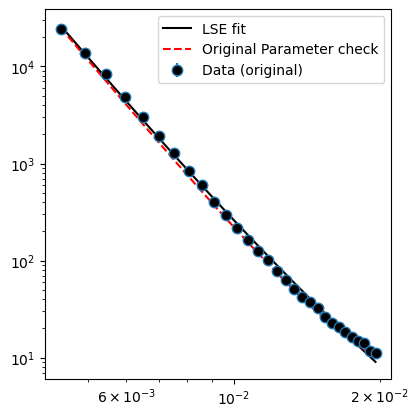

In [21]:

nobg_params = nobg_model.make_params(\
    aa=dict(value=2.3E-3, min=0.0),\
    kk=dict(value=0.02, min=0.001, max=0.05),\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=1.0, min=0.0),\
           )

# Paramters from the original analysis files
aa = 0.257919
kk = 0.2482739
bb = 4.4869E-07
cc = 1.71828E-10
qq = old_fit[0]
qq2= qq**2.0
qq4= qq**4.0
qq6= qq**6.0


par_check = aa / (kk**2.0 + qq2) + bb/qq4 + cc/qq6

emodel_params = emodel.make_params(\
    aa=dict(value=0.25, min=0.0),\
    kk=dict(value=0.24, min=0.001, max=0.5),\
    bb=dict(value=4.5E-07, min=0.0),\
    cc=dict(value=1.7E-10, min=0.0),\
    bg=dict(value=1.0, min=0.0)\
           )

enbg_params = enbg_model.make_params(\
    aa=dict(value=0.25, min=0.0),\
    kk=dict(value=0.24, min=0.001, max=0.5),\
    bb=dict(value=4.5E-07, min=0.0),\
    cc=dict(value=1.7E-10, min=0.0)\
           )

teubner_params = teubner_model.make_params(\
    bb=dict(value=200.0, min=0.0),\
    cc=dict(value=10.0, min=0.0),\
    bg=dict(value=10.0, min=0.0)\
           )



#result = teubner_model.fit(old_data[1], teubner_params, x=old_data[0], weights = 1.0/old_data[2])
#result = nobg_model.fit(old_data[1], nobg_params, x=old_data[0], weights = 1.0/old_data[2])
#result = emodel.fit(old_data[1], emodel_params, x=old_data[0], weights = 1.0/old_data[2])
result = enbg_model.fit(old_data[1], enbg_params, x=old_data[0], weights = 1.0/old_data[2])

print(result.fit_report())

fig, ax = plt.subplots()
ax.errorbar(old_data[0], old_data[1], old_data[2], markersize=7.5, fmt='o', mfc='black', label="Data (original)")
#ax.plot(spec[0], result.init_fit, '--', color='black', label="LSE initial")
ax.plot(old_data[0], result.best_fit, color="black", label="LSE fit")
#ax.plot(old_fit[0], old_fit[1], color="black",label="Original fit")
ax.plot(old_fit[0], par_check, ls="--", color='red', label="Original Parameter check")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_aspect(0.2)

ccval = result.params["cc"].value
bbval = result.params["bb"].value

zeta = (ccval * cscale) / (bbval * bscale)

# Affinescalarfunc has items nominal_value and std_dev:
cce = result.uvars["cc"].std_dev
bbe = result.uvars["bb"].std_dev

zetae = zeta * np.sqrt( (cce*cce / (ccval*ccval)) + (bbe*bbe / (bbval*bbval))  )

print("zeta:", zeta)
print("err:", zetae)

This implies also that the least squares algorithm in lmfit is different to the one in the other code from 20 years ago, maybe.

## Event Mode

The differences above do not prevent us from moving ahead and checking that the event mode analysis is consistent with the data analysis thus far.

data/ill/d11/ymnfe2/006314
data/ill/d11/ymnfe2/006315
data/ill/d11/ymnfe2/006018
Transmission: 0.010068542849775422
data/ill/d11/ymnfe2/006346
data/ill/d11/ymnfe2/006025
data/ill/d11/ymnfe2/006010
data/ill/d11/ymnfe2/006011
data/ill/d11/ymnfe2/006012
data/ill/d11/ymnfe2/006013
data/ill/d11/ymnfe2/006014
data/ill/d11/ymnfe2/006015
data/ill/d11/ymnfe2/006016
data/ill/d11/ymnfe2/006017
Beam centre: [31.00774403 31.43936935]
data/ill/d11/ymnfe2/006316
Data size: 3705796.0


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2949/4264629239.py:11: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


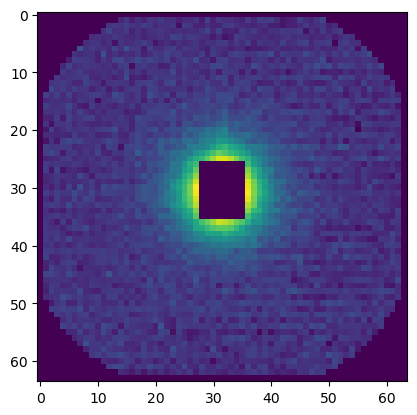

In [22]:
# Repeat all the loading steps above then resample the histogram to events

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import tqdm



sample_trans, sample_trans_sum, sample_trans_mon = read_sum(6314, 6315)
empty_trans, empty_trans_sum, empty_trans_mon = read_run(6018)

transmission = calculate_transmission(sample_trans, empty_trans, sample_trans_mon, empty_trans_mon)
print("Transmission:", transmission)

nuclear, non1, nuclear_mon = read_run(6346)
cadmium, non1, non2 = read_run(6025)

water, detsum, water_mon = read_sum(6010, 6017)
detector_mask = make_mask(water)

beam_centre = find_centre(sample_trans)
print("Beam centre:", beam_centre)

realdat, detsum, data_mon = read_run(6316)
print("Data size:", detsum)
realdat_masked = apply_mask(realdat, detector_mask)
water_masked = apply_mask(water, detector_mask)

#norm_realdat = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon)
#norm_divide = norm_water(realdat_masked, water_masked, data_mon=data_mon, water_mon=water_mon, divide=True)




In [23]:
events, weights = event_resample(realdat_masked, detector_distance_from(6010), wavelength_from(6010), beam_centre)

  0%|          | 0/64 [00:00<?, ?it/s]

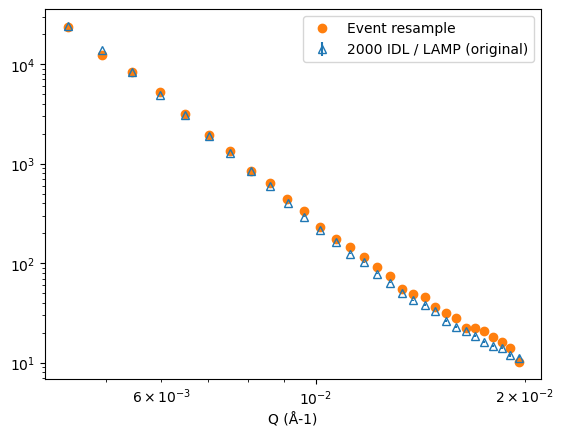

In [24]:


old_data = np.loadtxt("/Users/phillipbentley/Experimental_Work/PhD/y(mnfe)2/SANS/xp6/ymnfep6_0.dat", unpack=True,max_rows=30)

qmin = np.amin(old_data[0])
qmax = np.amax(old_data[0])
npts = old_data[0].size

dq = old_data[0,1]-old_data[0,0]

bins = np.linspace(qmin, qmax+dq, npts+1)

weights = np.ones_like(events)

circle_area_diff = (4.0 * np.pi * events)
square_approx = np.sqrt(2.0) # difference between area of a square and a circle?
no_idea_wtf = np.pi # This is obviously there from looking at the data but no clue why
norm = circle_area_diff # / (no_idea_wtf * square_approx)

# This seems to work.  Ross didn't know why the normalisation factor in LAMP was 1000x the beam monitors.
# Here 10,000x beam monitors divided by circle area is a good match to the data reduction.
weights = weights * 10000.0 / norm / data_mon


hist_check = np.histogram(events, bins=bins, weights = weights)

xvals = hist_check[1]
dx = xvals[1]-xvals[0]
#xvals = xvals + 0.5*dx

xvals = xvals[:-1]

yvals = hist_check[0]

fig, ax = plt.subplots()
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="2000 IDL / LAMP (original)")
ax.plot(xvals, yvals, marker='o', ls='None', label="Event resample")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
ax.legend()

You can see that there is some other effect going on (maybe detector efficiency calculations) but that is not important.  As soon as we demonstrate weighted event mode data analysis, we can put in whatever corrections are needed later.

In [25]:
events.size

3040584

This will need cluster / gpu to demonstrate in full, which we are ready for now.  Lets try a manageable subset:

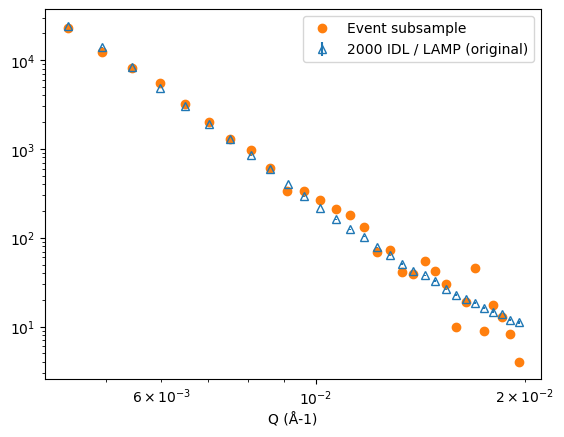

In [25]:
perm = np.random.permutation(len(events))

sh_events = events[perm]
sh_weights = weights[perm]

small_events = sh_events[:10000]
small_weights = sh_weights[:10000]

hist_check = np.histogram(small_events, bins=bins, weights = small_weights)

xvals = hist_check[1]
dx = xvals[1]-xvals[0]
#xvals = xvals + 0.5*dx

xvals = xvals[:-1]

yvals = hist_check[0]*300

fig, ax = plt.subplots()
ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="2000 IDL / LAMP (original)")
ax.plot(xvals, yvals, marker='o', ls='None', label="Event subsample")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
ax.legend()

## Develop custom MCMC Models for Porod / Teubner

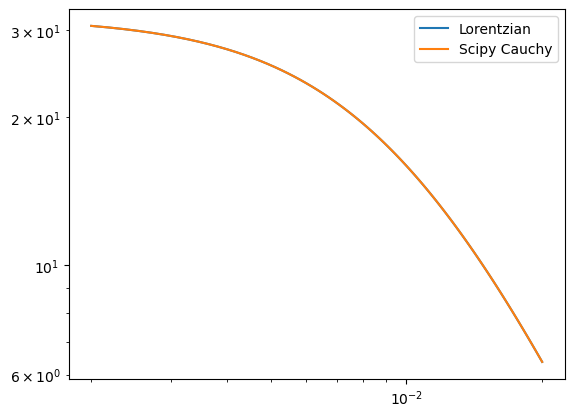

In [26]:
# Check that scipy cauchy distribution kappa matches our understanding of lorentzian scattering
# It does

def lor(x, kappa):
    t1 = kappa
    
    t2 = np.pi * np.power(x, 2.0) + np.pi * np.power(kappa, 2.0)
    
    return t1 / t2

testX = np.linspace(2.0E-3, 2.0E-02,100)
lorY = lor(x=testX, kappa=0.01)
spY = sp.stats.cauchy.pdf(x=testX, loc=0.0, scale=0.01)

fig,ax=plt.subplots()
plt.plot(testX, lorY, label="Lorentzian")
plt.plot(testX, spY, label="Scipy Cauchy")
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()

In [27]:
event_min = np.amin(events)
print(np.amin(events))
print(np.amax(events))
kappa_max = np.amax(events) / (2.0*np.pi)
print(kappa_max)

0.0025322618564522564
0.022569920996697346
0.00359211449181794


What zeta parameter are we looking for here?  The scaling parameters are all different when using normalised probability curves.

The B and C parameters for least squares fit are replaced by the two mixture components.  In least squares they are not normalised Pareto distributions.

There are missing multiplicative factors in the old parameters that we need to account for.

In [28]:
aa = 0.257919
kk = 0.2482739
bb = 4.4869E-07
cc = 1.71828E-10
zz = cc / bb

afactor = kk / np.pi
bfactor = (4.0-1.0) * event_min **(4.0-1.0)
cfactor = (6.0-1.0) * event_min **(6.0-1.0)

zeta_factor = bfactor / cfactor


print(afactor)
print(bfactor)
print(cfactor)
print(zeta_factor)

newa = aa / afactor
newb = bb / bfactor
newc = cc / cfactor
newsum = newa + newb + newc

newzeta = newc / newb
print(newa/newsum)
print(newb/newsum)
print(newc/newsum)
print(newc/newb)

ls_modes=np.array([newa/newsum, newb/newsum, newc/newsum])

0.07902803685140583
4.871324877859945e-08
5.206106769108671e-13
93569.43862090551
0.009528168744864752
0.02689097775025839
0.9635808535048768
35.83286790290167


aa    0.009435856253764308
kappa 0.003592114491817942
bb    0.026902228468179076
cc    0.9636619152780566
zeta  17.910447761194032
16202.932220571045
xvals [0.004399  0.0049224 0.0054458 0.0059692 0.0064926 0.007016  0.0075394
 0.0080628 0.0085862 0.0091096 0.009633  0.0101564 0.0106798 0.0112032
 0.0117266 0.01225   0.0127734 0.0132968 0.0138202 0.0143436 0.014867
 0.0153904 0.0159138 0.0164372 0.0169606 0.017484  0.0180074 0.0185308
 0.0190542 0.0195776]
lorentzian integral: 0.16020661269898284
porod integral: 0.9886555477092325
teubner integral: 0.9994272401653447
Lorentzian 0: 35.44950308877736
Porod 0.    : 681.973175721755
Teubner O.  : 1136.6219595362581
alpha [ 1.235  1.67  25.   ]
lorQ 0.009435856253764308
zeta4 0.013451114234089538
zeta6 0.9636619152780566
Norm Lorenztian 0: 221.2736571328958
Norm Porod 0.    : 689.7985626054727
Norm Teubner O.  : 1137.273344028742
lt1 [-1.09512912 -1.2359863  -1.37238735 -1.5037496  -1.62984351 -1.75066134
 -1.8663297  -1.97705231 -2.0830732

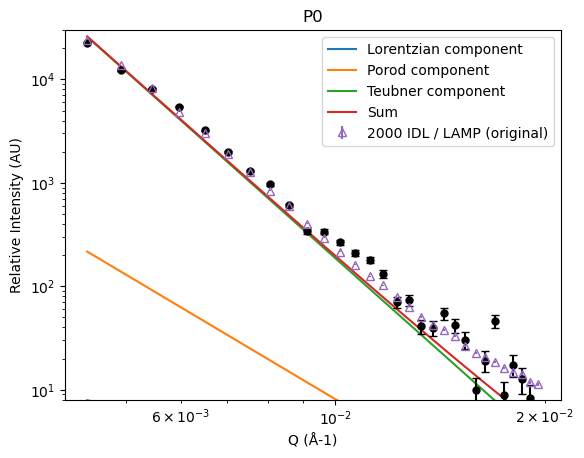

In [113]:
working_events = small_events
working_weights = small_weights

# Todo ---
# 
# It looks sensible if the porod term is scaled by 0.5 compared
# to the teubner term.  Figure out where that comes from
#
# Last step is to figure out what value zeta takes for the normalised
# porod and teubner ratio



class Porod:
    # Slightly modified so that alpha is actually the power of the pdf
    # This kind of follows the same modification as the wikipedia page on power laws

    def pdf(self, x, xmin, alpha):
        return x**(-alpha)
    
    def cdf(self, x, xmin, alpha):
        t1 = ((x* xmin)**(-alpha)) * ( (x**alpha)*xmin - x * xmin**alpha )
        t2 = alpha - 1.0
        return t1 / t2
    
    

class Porod_normalised:
    # Slightly modified so that alpha is actually the power of the pdf
    # This kind of follows the same modification as the wikipedia page on power laws

    def pdf(self, x, xmin, alpha):
        return ((alpha-1.0) / xmin) * (x/xmin)**(-alpha)
    
    def cdf(self, x, xmin, alpha):
        return 1.0 - (x/xmin)**(1.0-alpha)
    
    def quantile(self, p, xmin, alpha):
        return xmin * (1.0-p)**(1.0 / (1.0-alpha))
    
    def rvs(self, xmin, alpha, size=1):
        flat = np.random.uniform(size=size)
        return self.quantile(flat, xmin, alpha)

porod_obj = Porod_normalised()

q4_scale_factor = 0.5 

def dirichlet_mode(alpha):
    # Returns the mode of the dirichlet distribution
    # for a given array of alphas
    # i.e. it's the analytical peak location in the dirichlet distribution
    # representing the parameter values mapped from alphas
    # the alpha parameters are controlled by the markov chain monte carlo
    # not the weight parameters themselves.  In this way, the weight
    # parameters always sum to unity.
    
    # Dirichlet distro being the multi-dimensional beta distribution
    # Check out the wikipedia pages on beta distributions to understand
    # what is going on with the mixture weights and the dirichlet ;) 
    
    alpha = np.asarray(alpha)
    K = alpha.shape[0]
    
    alpha0 = np.sum(alpha, axis=0)
         
    x_mode = (alpha - 1.0) / (alpha0 - K)
    
    return x_mode



def cauchy(x, kappa):
    #t1 = kappa
    #t2 = np.pi * np.power(x, 2.0) + np.pi * np.power(kappa, 2.0)
    #return t1 / t2
    return sp.stats.cauchy.pdf(x=x, loc=0.0, scale=kappa)

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral of a cauchy distribution over the range of x values
    #t1 = np.arctan(xmax/kappa)
    #t2 = np.arctan(xmin/kappa)
    
    #return np.abs((t1 - t2)/np.pi)
    c1 = sp.stats.cauchy.cdf(x=xmin, loc=0.0, scale=kappa)
    c2 = sp.stats.cauchy.cdf(x=xmax, loc=0.0, scale=kappa)
    
    return c2-c1

def teubner_integral(xmin, xmax, power):
    # returns the integral of a porod term over the range of x values
    #t1 = 1.0 / xmin**(power-1.0)
    #t2 = 1.0 / xmax**(power-1.0)
    
    #return (1.0/(power-1.0)) * (t1 - t2)
    
    return porod_obj.cdf(xmax, xmin=xmin, alpha=power)
    

    
    
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    logKappa, a1, a2, a3 = theta
    
    alpha = np.array([a1, a2, a3])
    
    if\
        -6.0 <= logKappa <= kappa_max and\
        np.all(alpha > 1.0) and\
        np.all(alpha <= 40.0):
        return 0.0
    
    return -np.inf


    

def pmf(xvals, theta):
    
    logKappa, a1, a2, a3 = theta
    

    alpha = np.array([a1, a2, a3])
    x_mode = dirichlet_mode(alpha)

    kappa = 10.0**logKappa
    lorQ   = x_mode[0]
    zeta4  = q4_scale_factor * x_mode[1]
    zeta6  = x_mode[2]

    xmin = np.amin(xvals)
    xmax = np.amax(xvals)
    
    
    lor_int = cauchy_integral(xmin, xmax, kappa)
    q4_int = teubner_integral(xmin, xmax, 4.0)
    q6_int = teubner_integral(xmin, xmax, 6.0)
    
    # Basic lorentzian term
    arg1 = cauchy(x=xvals, kappa=kappa)# / lor_int
        
    arg2 = porod_obj.pdf(x=xvals, xmin=xmin, alpha=4.0)#/q4_int
    arg3 = porod_obj.pdf(x=xvals, xmin=xmin, alpha=6.0)#/q6_int
    
    
    linear_l = lorQ*arg1 + zeta4*arg2 + zeta6*arg3
    
    return linear_l



def calc_qvals(weights):
    # Computes q-values given weighting parameters
    
    wtot = np.sum( np.absolute(weights))
    return weights / wtot

    

def log_likelihood(theta, test=False, title=""):
    
    # This function is a "signal" teubner term sitting on a "background" lorentzian term
    
    logKappa, a1, a2, a3 = theta
    
    alpha = np.array([a1, a2, a3])
    
    x_mode = dirichlet_mode(alpha)

    kappa = 10.0**logKappa
    lorQ   = x_mode[0]
    zeta4  = q4_scale_factor * x_mode[1]
    zeta6  = x_mode[2]
    
    if test:
        verbose=True
        data = xvals
    else:
        verbose=False
        data = working_events
    
    xmin = np.amin(data)
    xmax = np.amax(data)
    
    weights = working_weights
    
    if data.shape != weights.shape:
        # Could be a test with a small run of histogrammed data
        # in that case, weights are unity
        weights = np.ones_like(data)
        
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    
    lor_int = cauchy_integral(xmin, xmax, kappa)
    q4_int = teubner_integral(xmin, xmax, 4.0)
    q6_int = teubner_integral(xmin, xmax, 6.0)
    
    t1 = lorQ * cauchy(x=data, kappa=kappa)*weights#/lor_int *
    lt1 = np.log(t1)
        
    t2 = zeta4 * porod_obj.pdf(x=data, xmin=xmin, alpha=4.0)*weights# / q4_int
    lt2 = np.log(t2)

    t3 = zeta6 * porod_obj.pdf(x=data, xmin=xmin, alpha=6.0)*weights# / q6_int
    lt3 = np.log(t3)
    
    tsum = t1 + t2 + t3
    
    graph_norm = np.sum(yvals) / np.sum(tsum)
       
    # Should we use np.logaddexp for this sum?  Something to consider...
    
    weighted_ll = np.logaddexp(lt1, lt2)
    weighted_ll = np.logaddexp(weighted_ll, lt3)
    
    weighted_ll_sum = np.sum(weighted_ll)
    
    result = lp + weighted_ll_sum
      
    if np.isnan(result):
        print("NaN encountered at", theta)
        verbose=True
        
    if verbose:
        print("xvals", xvals)
        print("lorentzian integral:", lor_int)
        print("porod integral:", q4_int)
        print("teubner integral:", q6_int)
        
        print("Lorentzian 0:", cauchy(x=xmin, kappa=kappa))
        print("Porod 0.    :", porod_obj.pdf(x=xmin, xmin=xmin, alpha=4.0))
        print("Teubner O.  :", porod_obj.pdf(x=xmin, xmin=xmin, alpha=6.0))
        
        print("alpha", alpha)
        print("lorQ", lorQ)
        print("zeta4", zeta4)
        print("zeta6", zeta6)
        
        print("Norm Lorenztian 0:", cauchy(x=xmin, kappa=kappa) / lor_int)
        print("Norm Porod 0.    :", porod_obj.pdf(x=xmin, xmin=xmin, alpha=4.0)/ q4_int)
        print("Norm Teubner O.  :", porod_obj.pdf(x=xmin, xmin=xmin, alpha=6.0)/ q6_int)
        print("lt1", lt1)
        print("lt2", lt2)
        print("lt3", lt3)
        
        y_max = np.amax(yvals)
        y_min = np.amin(yvals)
        if y_min <= 0.0:
            y_min = 1.0
            
        xplot =np.linspace(xmin, xmax, 20)
        
        fig,ax=plt.subplots()
        plt.plot(xvals, t1*graph_norm, label="Lorentzian component")
        #plt.plot(xvals, cauchy(xvals, 0.01), label="Actual lorentzian plot, WTF")
        plt.plot(xvals, t2*graph_norm, label="Porod component")
        plt.plot(xvals, t3*graph_norm, label="Teubner component")
        plt.plot(xvals, tsum*graph_norm, label="Sum")
        plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
        ax.errorbar(old_data[0], old_data[1], old_data[2], fmt='^', mfc='none', label="2000 IDL / LAMP (original)")
        plt.ylabel("Relative Intensity (AU)")
        plt.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([8.0, 30000.0])
        #ax.set_xlim([2.0E-3, 2.0E-2])
        ax.set_xlabel('Q (Å-1)')
        ax.set_title(title)
    
    return result

p0 = np.array([np.log10(kappa_max), 1.235, 1.67, 25.0])

p1 = np.array([-0.0,\
9.0,\
1.1,\
1.1])

# Scaled least squares modes are:
#0.009528168744864752
#0.02689097775025839
#0.9635808535048768


modes = dirichlet_mode([p0[1], p0[2], p0[3]])
print("aa   ", modes[0])
print("kappa", 10.0**p0[0])
print("bb   ", modes[1])
print("cc   ", modes[2])
print("zeta ", q4_scale_factor * modes[2]/modes[1])

print(log_likelihood(p0))

print(log_likelihood(p0, test=True, title="P0"))

#print(log_likelihood(p1, test=True, title="P1"))

In [114]:
ndim, nwalkers = 4, 32
#    aa=dict(value=0.25, min=0.0),\
#    kk=dict(value=0.24, min=0.001, max=0.5),\
#    bb=dict(value=4.5E-07, min=0.0),\
#    cc=dict(value=1.7E-10, min=0.0),\
#    bg=dict(value=1.0, min=0.0)\



p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100, progress=True)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.64it/s]


In [115]:
labels = ["log(kappa)", "a1", "a2", "a3"]
samples = sampler.get_chain()

def parameter_dump(samples):
    for i in range(ndim):
        print(labels[i], np.mean(samples[:, :, i]))
        
    print()
            
    for i in range(ndim):
        print(np.mean(samples[:, :, i]))

parameter_dump(samples)

kappa1 = 10.0**np.mean(samples[:,:,0])
alpha1 = np.mean(samples[:,:,1])
alpha2 = np.mean(samples[:,:,2])
alpha3 = np.mean(samples[:,:,3])

modes = dirichlet_mode([alpha1, alpha2, alpha3])
print("aa   ", modes[0])
print("kappa", kappa1)
print("bb   ", modes[1])
print("cc   ", modes[2])
print("zeta ", q4_scale_factor * modes[2]/modes[1])

log(kappa) -2.1597883105376994
a1 4.302191979126797
a2 1.060978788440112
a3 27.901762183260438

-2.1597883105376994
4.302191979126797
1.060978788440112
27.901762183260438
aa    0.10910950916336083
kappa 0.006921682743644855
bb    0.00201483309211974
cc    0.8888756577445195
zeta  220.58295082134137


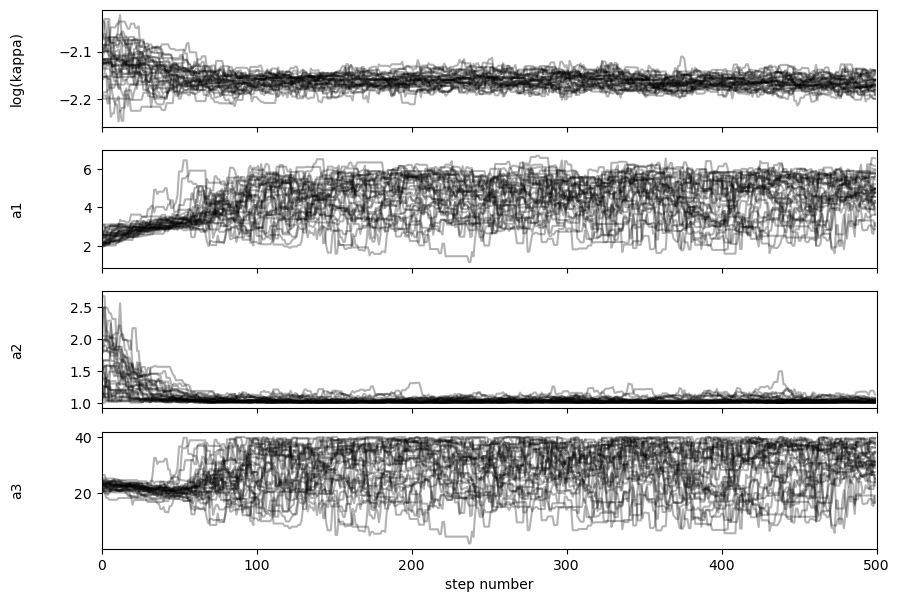

In [116]:
#tau = sampler.get_autocorr_time()
#print("Autocorrelation time:", tau)

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["log(kappa)", "a1", "a2", "a3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

[-2.14512804  2.87948112  1.03157233 15.66191659]


Text(0.5, 0, 'Q (Å-1)')

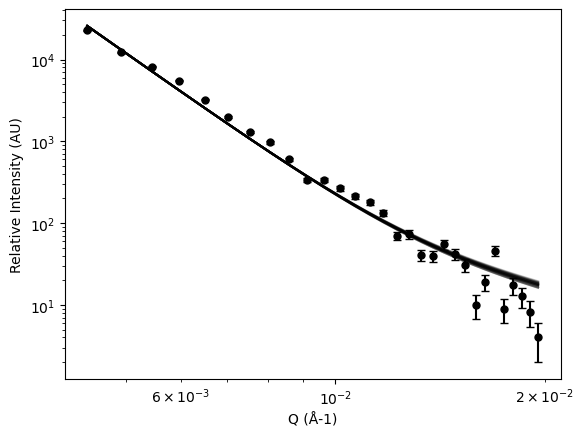

In [117]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(yvals)

print(flat_samples[0])

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.2 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')

k.  : 0.006929394682019796 +/- 0.00033452579543432156
A   : 0.10843257736846533 +/- 0.011560462486902925
B   : 0.002276669020845188 +/- 0.005212024730400484
C   : 0.8892907536106894 +/- 0.008813989889755715
Zeta: 390.61046883334416 +/- 894.2408774329908


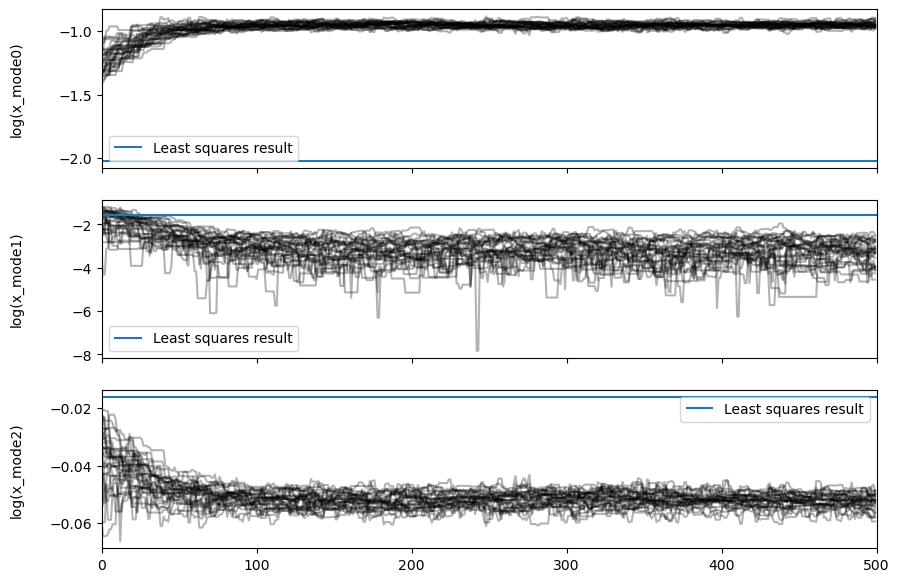

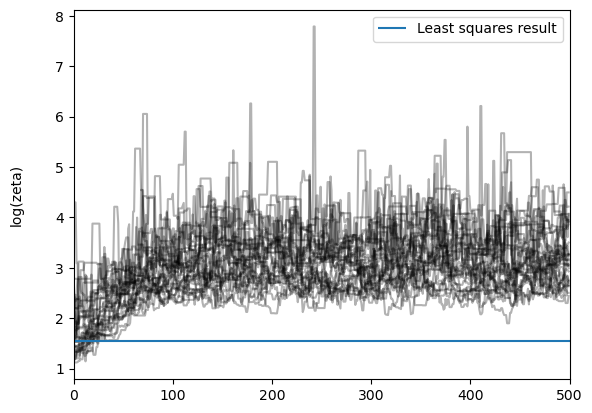

In [118]:

samples = sampler.get_chain()
a1=samples[:, :, 1]
a2=samples[:, :, 2]
a3=samples[:, :, 3]

alpha0 = a1 + a2 + a3
K = 3.0

alpha = np.array([a1, a2, a3])

alpha0 = np.sum(alpha)
x_mode = dirichlet_mode(alpha)# (alpha - 1.0) / (alpha0 - K)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["log(x_mode0)", "log(x_mode1)", "log(x_mode2)"]

kappa = np.mean(10.0**samples[:,:,0])
aa = np.mean(x_mode[0])
bb = np.mean(x_mode[1])
cc = np.mean(x_mode[2])

kappa_sigma = np.std(10.0**samples[:,:,0])
asigma = np.std(x_mode[0])
csigma = np.std(x_mode[2])
bsigma = np.std(x_mode[1])

zeta = cc / bb

zeta_sigma = zeta*np.sqrt((csigma/cc)**2.0 + (bsigma/bb)**2.0)

print("k.  :", kappa, "+/-", kappa_sigma)
print("A   :", aa, "+/-", asigma)
print("B   :", bb, "+/-", bsigma)
print("C   :", cc, "+/-", csigma)
print("Zeta:", zeta, "+/-", zeta_sigma)

for component in range(3):
    ax = axes[component]
    ax.plot(np.log10(x_mode[component]), "k", alpha=0.3)
    ax.set_xlim(0, len(x_mode[component]))
    ax.set_ylabel(labels[component])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.hlines(np.log10(ls_modes[component]), 0, len(x_mode[0]), label="Least squares result")
    ax.legend()

fig, ax = plt.subplots()
ax.plot(np.log10(x_mode[2]/x_mode[1]), "k", alpha=0.3)
ax.set_xlim(0, len(x_mode[component]))
ax.set_ylabel("log(zeta)")
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.hlines(np.log10(newzeta), 0, len(x_mode[0]), label="Least squares result")
ax.legend()

In [105]:
import seaborn as sns

def linear_parameter_analysis(param_data, ls_value=None, title="", logscale=False):
    param_mean = np.mean(param_data)
    param_stddev= np.std(param_data)
    
    barmin = param_mean - param_stddev
    barmax = param_mean + param_stddev
    
    truetxt = "LS value " + str(ls_value)
    fittxt = "Fit value " + str(param_mean)
    
    fig,ax=plt.subplots()
    
    hst=sns.histplot(param_data, log_scale=logscale)
    #plt.gca().set(title='Seaborn histogram, logarithmic x axis')
    #plt.show()
    print(hst)
    #hst=plt.hist(param_data, 100, color='k', histtype="step")
    #ytop = np.amax(hst[0])
    #plt.xlabel(title)
    #plt.ylabel("p(log(kappa))")
    #if ls_value is not None:
    #    plt.vlines(ls_value, 0, ytop*0.9, color='blue')
    #plt.vlines(param_mean, 0, ytop, color="red")
    #plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
    #plt.xlim([true_kappa*0.7, true_kappa*1.3])
    #if ls_value is not None:
    #    plt.text(ls_value*1.005, ytop*0.87, truetxt, color="blue")
    #plt.text(param_mean*1.005, ytop*0.97, fittxt, color="red")
    #if logscale:
    #    ax.set_xscale('log')
    #    ax.set_yscale('log')
    


def log_parameter_analysis(log_param_data, ls_value=None, title=""):
    log_param_mean = np.mean(log_param_data)
    log_param_stddev= np.std(log_param_data)
    
    param_mean = 10.0**log_param_mean

    # see propagation of uncertainty for f=a^(b*A)
    param_stddev = param_mean * np.log(10.0) * log_param_stddev
    param_data = 10.0**log_param_data
    
    
    barmin = param_mean - param_stddev
    barmax = param_mean + param_stddev
    
    truetxt = "LS value " + str(ls_value)
    fittxt = "Fit value " + str(param_mean)

    fig,ax=plt.subplots()
    hst=plt.hist(param_data, 100, color='k', histtype="step")
    ytop = np.amax(hst[0])
    plt.xlabel(title)
    #plt.ylabel("p(log(kappa))")
    if ls_value is not None:
        plt.vlines(ls_value, 0, ytop*0.9, color='blue')
    plt.vlines(param_mean, 0, ytop, color="red")
    plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
    #plt.xlim([true_kappa*0.7, true_kappa*1.3])
    if ls_value is not None:
        plt.text(ls_value*1.005, ytop*0.87, truetxt, color="blue")
    plt.text(param_mean*1.005, ytop*0.97, fittxt, color="red")
    #ax.set_xscale('log')
    

k.  : 0.0068672912650692254
A   : 0.11133136649429032
B   : 0.0013145501433498464
C   : 0.8873540833623598
C/B : 675.0249032730924
Zeta array: 6377.948296105721
Axes(0.125,0.11;0.775x0.77)


/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


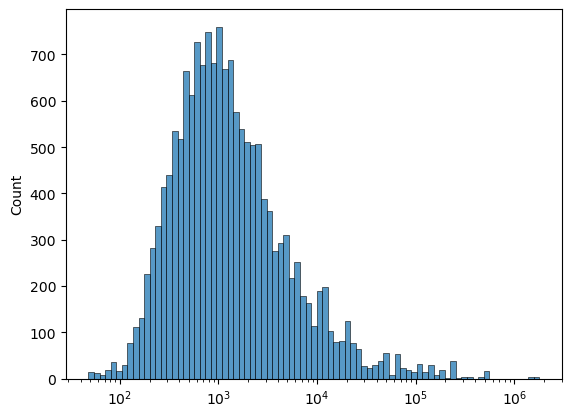

In [112]:
samples=sampler.get_chain(flat=True)

kappa=samples[:,0]
a1=samples[:, 1]
a2=samples[:, 2]
a3=samples[:, 3]

alpha0 = a1 + a2 + a3
K = 3.0

alpha = np.array([a1, a2, a3])

alpha0 = np.sum(alpha)
x_mode = dirichlet_mode(alpha)

zeta_dist = x_mode[2]/x_mode[1]

zkeep = np.isfinite(zeta_dist)

zeta_filt=zeta_dist[zkeep]

print("k.  :", np.mean(10.0**kappa))
print("A   :", np.mean(x_mode[0]))
print("B   :", np.mean(x_mode[1]))
print("C   :", np.mean(x_mode[2]))
print("C/B :", np.mean(x_mode[2])/np.mean(x_mode[1]))
print("Zeta array:", np.mean(x_mode[2] / x_mode[1]))

#log_parameter_analysis(kappa, ls_value=0.24, title='kappa')
#linear_parameter_analysis(x_mode[0], ls_value=ls_modes[0], title='Lorentzian Amplitude')
#linear_parameter_analysis(x_mode[1], ls_value=ls_modes[1], title="Porod Amplitude")
#linear_parameter_analysis(x_mode[2], ls_value=ls_modes[2], title="Teubner Amplitude")
linear_parameter_analysis(zeta_filt, ls_value=newzeta, title="Zeta", logscale=True)



In [53]:
samples=sampler.get_chain(flat=True)

acc_frac = np.mean(sampler.acceptance_fraction)
if acc_frac > 0.7:
    diag_result = ", probably OK"
else:
    diag_result = ", this isn't"

log_kappa_mean = np.mean(samples[:,0])
log_kappa_stddev = np.std(samples[:,0])

kappa_mean = log_kappa_mean
kappa_stddev = log_kappa_stddev

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev


bg_fraction = 10.0**mix_mean

ls_kappa = np.log10(0.24)

truetxt = "LS value " + str(ls_kappa)
fittxt = "Fit value " + str(kappa_mean)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("log(kappa)")
plt.ylabel("p(log(kappa))")
plt.vlines(ls_kappa, 0, ytop*0.9, color='blue')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(ls_kappa*1.005, ytop*0.87, truetxt, color="blue")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")
print("Acceptance fraction", acc_frac, "(should be high", diag_result, ")")
print("kappa estimate       :", kappa_mean, " (historical LS fit value =", ls_kappa,")")

print("kappa std.dev.       :", np.std(samples[:,0]))

NameError: name 'mix_mean' is not defined

zeta estimate       : 5.205027398951649  (historical LS fit value = 0.0003833697228751769 )
zeta std.dev.       : 2.4436936543530625


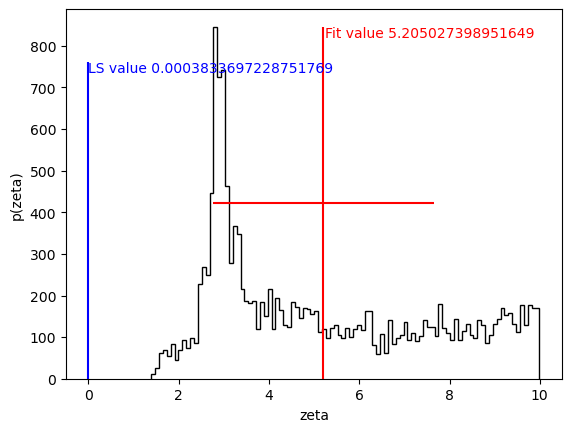

In [54]:
zeta_mean = np.mean(samples[:,1])
zeta_stddev = np.std(samples[:,1])

barmin = zeta_mean - zeta_stddev
barmax = zeta_mean + zeta_stddev

ls_zeta = sliding_zeta

truetxt = "LS value " + str(ls_zeta)
fittxt = "Fit value " + str(zeta_mean)

hst=plt.hist(samples[:,1], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("zeta")
plt.ylabel("p(zeta)")
plt.vlines(ls_zeta, 0, ytop*0.9, color='blue')
plt.vlines(zeta_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(ls_zeta*1.005, ytop*0.87, truetxt, color="blue")
plt.text(zeta_mean*1.005, ytop*0.97, fittxt, color="red")
print("zeta estimate       :", zeta_mean, " (historical LS fit value =", ls_zeta,")")

print("zeta std.dev.       :", zeta_stddev)

log zeta estimate       : -0.012182053884348872  (historical LS fit value = 0.9728922424937357 )
log zeta std.dev.       : 0.05341601984911094


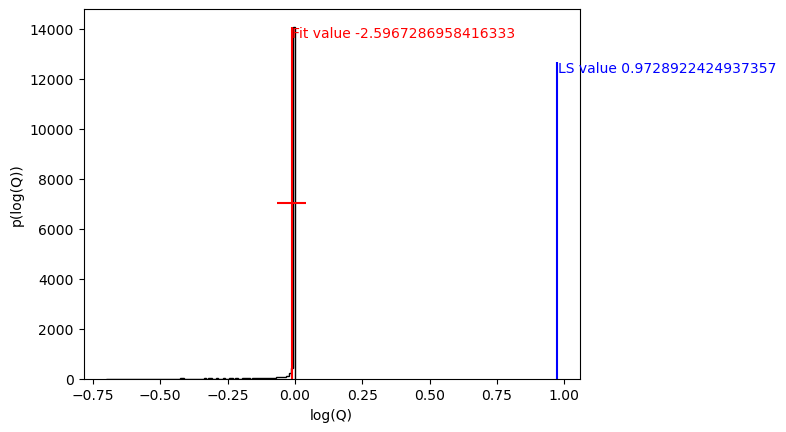

In [113]:
log_q_mean = np.mean(samples[:,2])
log_q_stddev = np.std(samples[:,2])

barmin = log_q_mean - log_q_stddev
barmax = log_q_mean + log_q_stddev

#ls_zeta = sliding_zeta

#truetxt = "LS value " + str(ls_zeta)
#fittxt = "Fit value " + str(log_zeta_mean)

hst=plt.hist(samples[:,2], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("log(Q)")
plt.ylabel("p(log(Q))")
plt.vlines(ls_zeta, 0, ytop*0.9, color='blue')
plt.vlines(log_q_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(ls_zeta*1.005, ytop*0.87, truetxt, color="blue")
plt.text(log_q_mean*1.005, ytop*0.97, fittxt, color="red")
print("log zeta estimate       :", log_q_mean, " (historical LS fit value =", ls_zeta,")")

print("log zeta std.dev.       :", log_q_stddev)